In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
pd.set_option('display.max_rows', 100)

import numpy as np
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.express as px
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.arima import auto_arima
from pmdarima import model_selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
api_key = "6e68642c-8403-4caa-af31-bda40b8c67f6" # web token for RESTful API
country_code = "10Y1001A1001A83F" # Germany
time_zone = "Europe/Berlin" # time zone for Germany
start_date = "20171225"
end_date = "20180102"

In [3]:
class SARIMADataset:
    """
    Fetch and preprocess ENTSO-E load and generation data. Caluclate SARIMA predictions and residuals.
    """
    def __init__(
        self,
        start_date, 
        end_date,                          # overall end date
        api_key, # web token for RESTful API
        country_code = "10Y1001A1001A83F", # country code (default: Germany)
        time_zone = "Europe/Berlin" # time zone for Germany
                ):
        """
        Initialize SARIMA dataset.
        Params
        ------
        start_date : str
                     overall start date as "YYYYMMDD"
        end_date : str
                   overall end date as "YYYYMMDD"
        api_key : str
                  web token for RESTfulAPI access to ENTSO-E transparency platform
        country_code : str
                       country code
        time zone : str
                    time zone
        """
        self.start_date = start_date
        self.end_date = end_date
        self.country = country_code
        self.time_zone = time_zone
        self.api_key = api_key
        self.df = None
        self.original_headers = None
        self.errors = None
        self.fetch_data()
        #self.calculate_pslps()
        #self.calculate_sarima()
        #self.calculate_errors()
    
    def _get_load_intervals(self):
        """
        Get time points for sequential data loading from ENTSO-E transparency platform.
        
        For one request, the time delta for loading data from the platform is limited to one year.
        
        
        Returns
        -------
        pd.Series
        pandas series with timestamps of time points to consider between start and end date
        """
        # Convert start and end dates to timestamps.
        start = pd.Timestamp(self.start_date, tz=self.time_zone)
        end = pd.Timestamp(self.end_date, tz=self.time_zone)
    
        # Create series from start and end timestamps.
        start_series = pd.Series(pd.Timestamp(self.start_date))
        end_series = pd.Series(pd.Timestamp(self.end_date))
        
        # Create date range from start and end dates and determine year starts within range.
        # Convert data range to series.
        dates = pd.date_range(start=self.start_date, end=self.end_date, freq="YS", inclusive="both").to_series()
    
        # Check whether start date itself is year start.
        # If not, prepend to dates to consider for data loading.
        if not start.is_year_start:
            dates = pd.concat([start_series, dates], ignore_index=True)
    
        # Check whether end date itself is year start.
        # If not, append to dates to consider for data loading.
        if not end.is_year_start:
            dates = pd.concat([dates, end_series], ignore_index=True)
            
        return dates
        
        
    def _load_data(self, start_date, end_date):
        """
        Load actual load and actual aggregated generation per production type for requested time interval.
        Params
        ------
        start_date : str
                     start date as "yyyymmdd"
        end_date : str
                   end date as "yyyymmdd"
                    
        Returns
        -------
        pd.DataFrame with time points as indices and load + generation per type as columns.
        """
        from entsoe import EntsoePandasClient
        # Initialize client and settings.
        client = EntsoePandasClient(api_key=self.api_key)
        start = pd.Timestamp(start_date, tz=self.time_zone)
        end = pd.Timestamp(end_date, tz=self.time_zone)
        # Query data and save to dataframe.
        df_load = client.query_load(self.country, start=start, end=end)
        print(f"Actual load has shape {df_load.shape}.")
        df_gen = client.query_generation(self.country, start=start, end=end, psr_type=None)
        df_gen.columns = [" ".join(a) for a in df_gen.columns.to_flat_index()]
        print(f"Actual generation per production type has shape {df_gen.shape}.")
        df_final = pd.concat([df_load, df_gen], axis=1) # Concatenate dataframes in columns dimension.
        print(f"Concatenated data frame has shape {df_final.shape}.")
        
        return df_final

    
    def fetch_data(self, drop_consumption=True):
        """
        Fetch actual load and generation per type from ENTSO-E transparency platform 
        for requested time interval. Set resulting dataframe as attribute.
        
        Parameters
        ----------
        drop_consumption : Bool
                           Drop columns containing actual consumption.
        """
        # Determine sequence of dates to consider when loading data.
        dates = self._get_load_intervals()
        print(f"Consider the following dates:\n{dates}")
        df_list = []
        
        for i, _ in enumerate(dates):
    
            if i == dates.shape[0] - 1:
                df_final = pd.concat(df_list, axis=0) # Concatenate dataframes along time axis (index).
                df_final.index = pd.to_datetime(df_final.index, utc=True).tz_convert(tz="UTC+01:00")
    
                # Drop columns containing actual consumption?
                if drop_consumption:
                    print("Dropping columns containing actual consumption...")
                    df_final.drop(list(df_final.filter(regex='Consumption')), axis=1, inplace=True)
                original_headers = df_final.columns

                print("Creating columns for PSLP calculation...")
                for header in original_headers:
                    df_final[str(header) + " PSLP"] = pd.Series(dtype='float')
                
                print("Returning final data frame...")
                self.df = df_final
                self.original_headers = original_headers
                return
                
            try:
                print(f"Trying to load data chunk for time interval [{dates[i]}, {dates[i+1]}]...")
                df_temp = self._load_data(start_date=dates[i], end_date=dates[i+1])
                print(df_temp.shape)
                df_list.append(df_temp)
                print("Loading successful!")
                
            except Exception as e:
                print(f"Loading failed!", e)
                continue

    @staticmethod            
    def get_pslp_category(date, weekday=None, holiday=None, country_code='DE'):
        """
        Get PSLP category from date, weekday information, and holiday information.
        0 : weekday
        1 : Saturday
        2 : Sunday and holiday
        
        Params
        ------
        date : str
               date in 'YYYYMMDD' format
        weekday : int
                  corresponding weekday
                  0 - Mon, 1 - Tue, 2 - Wed, 3 - Thu, 4 - Fri, 5 - Sat, 6 - Sun
        holiday : Bool
                  True if public holiday, False if not.
        
        Returns
        -------
        int : PSLP category
        """
        # Convert string-type date to datetime object.
        if type(date) is str:
            date = pd.to_datetime(date)
        
        # Assign weekday if not given.
        if weekday is None:
            weekday = date.weekday()
        
        # Assign holiday category if not given.
        if holiday is None:
            import holidays
            holiday = date in holidays.country_holidays(country_code)
        
        # Special treatment for Christmas eve and New year's eve as Saturdays.
        if ( date.day == 24 or date.day == 31 ) and date.month == 12 and weekday != 6:
            pslp_category = 1
        # weekdays
        elif weekday < 5 and holiday is False:
            pslp_category = 0
        # Saturdays
        elif weekday == 5 and holiday is False:
            pslp_category = 1
        # Sundays and holidays
        elif weekday == 6 or holiday is True:
            pslp_category = 2
        return pslp_category
    
    
    def _assign_pslp_categories(self, country_code="DE"):
        """
        Assign PSLP categories to dates in dataframe's datetime index.
    
        0 is weekday, 1 is Saturday, 2 is Sunday or holiday.
        Special treatment for Christmas eve and New Year's eve (as Saturdays).
    
        Params
        ------
        df : pandas.Dataframe
        country_code : str
                       country to determine holidays for
        Returns
        -------
        pandas.Dataframe
        Dataframe amended by weekday information, holiday information, and PSLP category
        """
    
        import holidays
        
        # Get holidays in specified country.
        country_holidays = holidays.country_holidays(country_code) # Passing a state is also possible!
    
        s = self.df.index.to_series()                                # Convert datetime index to series.
        dates = s.dt.date                                       # Get plain dates from datetime objects.
        weekdays = s.dt.weekday                                 # Get weekdays from datetime objects.
        holidays = [date in country_holidays for date in dates] # Determine holidays.
        pslp_category = []
        
        for d, wd, hd in zip(dates, weekdays, holidays):
            pslp_category.append(self.get_pslp_category(d, wd, hd))
            
        self.df["PSLP Category"] = pslp_category
        self.df["Holiday"] = holidays
        self.df["Weekday"] = weekdays
    
    
    def calculate_residuals(self):
        """
        Calculate residuals of actual data w.r.t PSLPs.
        """
        for header in self.original_headers:
            self.df[header+" Residuals"] = self.df[header] - self.df[header+" SARIMA"]
    
    
    def plot_data(self):
        """
        Plot preprocessed load and generation data.
        """
        from plotly.subplots import make_subplots
        import plotly.graph_objects as go
    
        num_rows = len(self.original_headers)
        
        fig = make_subplots(rows=num_rows, cols=1, subplot_titles=(self.original_headers))
    
        for i, header in enumerate(self.original_headers):
            fig.add_trace(go.Scatter(x = self.df.index, y = self.df[header], name=header), row=i+1, col=1)
            fig.add_trace(go.Scatter(x = self.df.index, y = self.df[header+" PSLP"], name=header+" PSLP"), row=i+1, col=1)
            fig.add_trace(go.Scatter(x = self.df.index, y = self.df[header+" Residuals"], name=header+" Residuals"), row=i+1, col=1)
    
        fig.update_layout(height=10000, width=1200)
        fig.show()
        
       
    def calculate_errors(self):
        """
        Calculate forecasting errors for preprocessed ENTSO-E load and generation data.  
        """
        from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
        errors = {}
        for header in self.original_headers:
            temp = pd.concat([self.df[header], self.df[header+" PSLP"]], axis=1).dropna()
            mae = mean_absolute_error(temp[header], temp[header+" PSLP"])
            mape = mean_absolute_percentage_error(temp[header], temp[header+" PSLP"])
            mse = mean_squared_error(temp[header], temp[header+" PSLP"])
            errors[header] = {"MAE": mae, "MAPE": mape, "MSE": mse}
        self.errors = errors

In [4]:
SarimaData = SARIMADataset(start_date, end_date, api_key, country_code, time_zone)

Consider the following dates:
0   2017-12-25
1   2018-01-01
2   2018-01-02
dtype: datetime64[ns]
Trying to load data chunk for time interval [2017-12-25 00:00:00, 2018-01-01 00:00:00]...
Actual load has shape (672, 1).
Actual generation per production type has shape (672, 32).
Concatenated data frame has shape (672, 33).
(672, 33)
Loading successful!
Trying to load data chunk for time interval [2018-01-01 00:00:00, 2018-01-02 00:00:00]...
Actual load has shape (96, 1).
Actual generation per production type has shape (96, 20).
Concatenated data frame has shape (96, 21).
(96, 21)
Loading successful!
Dropping columns containing actual consumption...
Creating columns for PSLP calculation...
Returning final data frame...


In [5]:
def plot_autocorrelations(data):
    """Plot ACF and PACF for given data."""
    plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
    # Original series
    fig, axes = plt.subplots(3, 3)
    axes[0, 0].plot(data.to_numpy()); axes[0, 0].set_title(f'Original Series')
    plot_acf(data.to_numpy(), ax=axes[0, 1])
    plot_pacf(data.to_numpy(), ax=axes[0, 2], method='ywm')

    # 1st-order differencing
    axes[1, 0].plot(data.diff().to_numpy()); axes[1, 0].set_title(f'1st-Order Differencing')
    plot_acf(data.diff().dropna().to_numpy(), ax=axes[1, 1])
    plot_pacf(data.to_numpy(), ax=axes[1, 2], method='ywm')

    # 2nd-order differencing
    axes[2, 0].plot(data.diff().diff().to_numpy()); axes[2, 0].set_title(f'2nd-Order Differencing')
    plot_acf(data.diff().diff().dropna().to_numpy(), ax=axes[2, 1])
    plot_pacf(data.to_numpy(), ax=axes[2, 2], method='ywm')
    plt.tight_layout()
    plt.show()

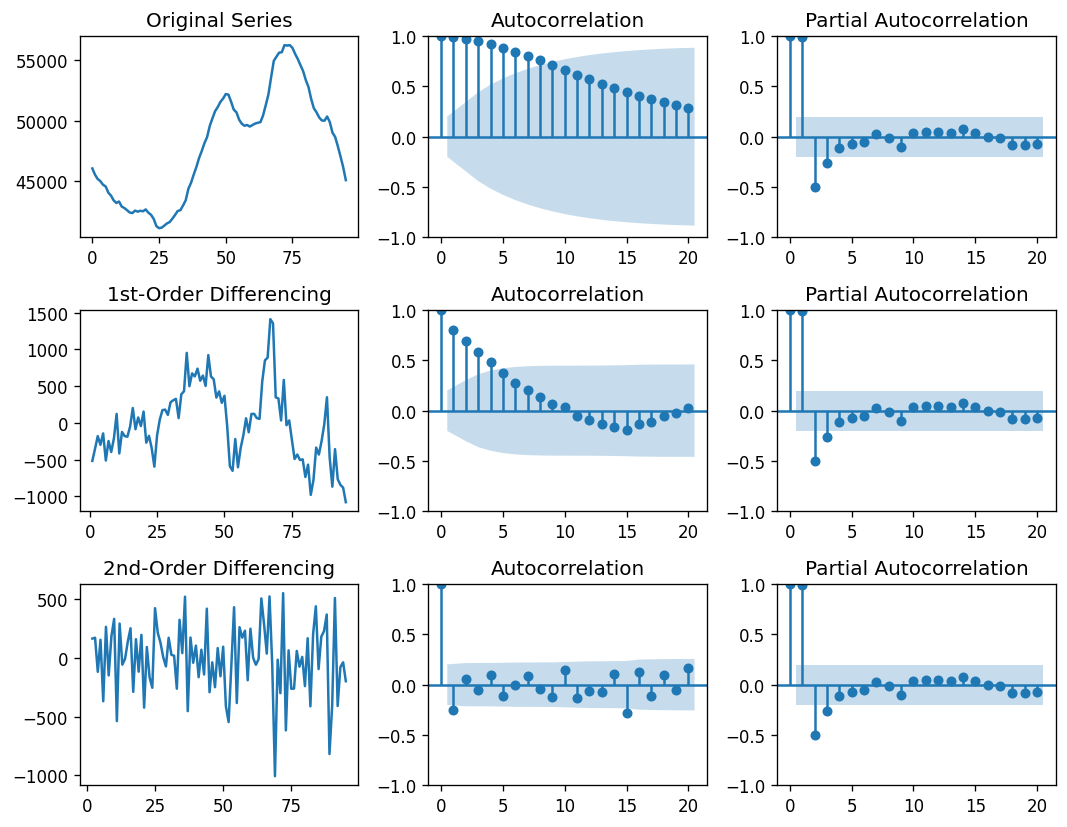

In [6]:
data_test = SarimaData.df["Actual Load"].loc["2018-01-01"]
plot_autocorrelations(data_test)

In [7]:
def split_train_test(df, train_fraction=0.75, seasonal_cycle=96):
    """
    Perform season-based train-test split of input data.
    Params
    ------
    df : pandas.DataFrame
         overall dataset
    train_fraction : float
                     fraction of data to use for training
    seasonal_cycle : int
                     number of data points in each season
                     Default 96 corresponds to 15min time resolution.
    
    Returns
    -------
    df_train : pandas.DataFrame
               train dataset
    df_test : pandas.DataFrame
              test dataset
    """
    overall_days = int(SarimaData.df.shape[0] / seasonal_cycle)
    train_days = int(train_fraction * overall_days)
    test_days = overall_days - train_days
    return model_selection.train_test_split(df, train_size=train_days, test_size=test_days)

In [10]:
seasonal_cycle = 96
train_fraction = 0.75
data = SarimaData.df["Actual Load"]
data_train, data_test = split_train_test(data, train_fraction=train_fraction, seasonal_cycle=seasonal_cycle)
print("Pre-compute (seasonal) differencing order to accelerate auto-ARIMA...")
# Estimate order of differencing d by performing a stationarity test for different d's. 
# Selects max. value d for which time series is judged stationary by statistical test.
# Default unit root test of stationarity: Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
d = ndiffs(data, test='kpss')
# Estimate order of seasonal differencing D by performing stationarity test of seasonality for different D's. 
# Selects max. value D for which time series is judged seasonally stationary by statistical test.
# Default unit root test of stationarity: Osborn-Chui-Smith-Birchenhall (OCSB)
D = nsdiffs(data, m=seasonal_cycle, test='ocsb')
print(f"Differencing order is {d}. Seasonal differencing order is {D}.")

Pre-compute (seasonal) differencing order to accelerate auto-ARIMA...
Differencing order is 1. Seasonal differencing order is 0.


In [12]:
print("Automatically discover optimal order for SARIMAX model with `auto_arima`...")
start_p = 1
start_q = 1
max_p = 3
max_q = 3
start_P = 1
start_Q= 1
max_P = 2
max_Q = 2
model = auto_arima(data.values, 
                   start_p=start_p, 
                   d=d, 
                   start_q=start_q,
                   max_p=max_p,
                   max_q=max_q,
                   start_P=start_P,
                   start_Q=start_Q,
                   max_P=max_P,
                   max_Q=max_Q,
                   D=D, 
                   m=seasonal_cycle,
                   trace=True
                  )
print("DONE.")
print(model)
print(type(model))
model.summary()

Automatically discover optimal order for SARIMAX model with `auto_arima`...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[96] intercept   : AIC=inf, Time=44.58 sec
 ARIMA(0,1,0)(0,0,0)[96] intercept   : AIC=12042.467, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[96] intercept   : AIC=inf, Time=17.67 sec
 ARIMA(0,1,1)(0,0,1)[96] intercept   : AIC=inf, Time=14.33 sec
 ARIMA(0,1,0)(0,0,0)[96]             : AIC=12040.472, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[96] intercept   : AIC=inf, Time=17.84 sec
 ARIMA(0,1,0)(0,0,1)[96] intercept   : AIC=inf, Time=35.59 sec
 ARIMA(0,1,0)(1,0,1)[96] intercept   : AIC=inf, Time=22.44 sec
 ARIMA(1,1,0)(0,0,0)[96] intercept   : AIC=11552.915, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[96] intercept   : AIC=11409.137, Time=12.45 sec
 ARIMA(1,1,0)(1,0,1)[96] intercept   : AIC=inf, Time=34.62 sec
 ARIMA(1,1,0)(0,0,2)[96] intercept   : AIC=inf, Time=128.49 sec
 ARIMA(1,1,0)(1,0,2)[96] intercept   : AIC=inf, Time=315.80 sec
 ARIMA(2,1,0)(0,0,1)[96] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  768
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 96)   Log Likelihood               -5557.225
Date:                                 Thu, 16 Feb 2023   AIC                          11128.450
Time:                                         13:41:23   BIC                          11160.948
Sample:                                              0   HQIC                         11140.959
                                                 - 768                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.2242      3.849     -1.098      0.272     -11.768       3.320
ar.L1          0.3063      0.007     42.382      0.000       0.292       0.320
ar.L2          0.2904      0.012     23.522      0.000       0.266       0.315
ar.S.L96       0.8251      0.041     19.929      0.000       0.744       0.906
ma.S.L96      -0.5754      0.056    -10.250      0.000      -0.685      -0.465
ma.S.L192      0.0925      0.042      2.209      0.027       0.010       0.175
sigma2       8.75e+04   3226.369     27.121      0.000    8.12e+04    9.38e+04
===================================================================================
Ljung-Box (L1) (Q):                  15.89   Jarque-Bera (JB):              2211.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.42
Prob(H) (two-sided):                  0.06   Kurtosis:                        11.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
type(model)
model.summary()
# Serialize model.
with open('sarima.pkl', 'wb') as pkl:
    pickle.dump(model, pkl)

# You can still make predictions from the model at this point
model.predict(n_periods=5)

array([45099.03664838, 44470.95820899, 43900.6761514 , 43426.26576683,
       43093.98520125])

## Refreshing your SARIMAX models
There are two ways to keep models up to date with `pmdarima`:
1. Periodically, a model will need to be refreshed given new observations. One can either re-use `auto-arime`-estimated order terms or re-fitting altogether.

In [ ]:
for header in SarimaData.original_headers:
    # Original data.
    data = SarimaData.df[header]
    dates = [pd.to_datetime(d).strftime('%Y-%m-%d') for d in data.index.to_series().dt.date.drop_duplicates().tolist()]
    # Get train fraction from original data.
    data_train = SarimaData.df[header].head(train_days * seasonal_cycle)
    dates_train = [pd.to_datetime(d).strftime('%Y-%m-%d') for d in data_train.index.to_series().dt.date.drop_duplicates().tolist()]
    # Get test fraction from original data.
    data_test = SarimaData.df[header].tail(test_days * seasonal_cycle)
    dates_test = [pd.to_datetime(d).strftime('%Y-%m-%d') for d in data_test.index.to_series().dt.date.drop_duplicates().tolist()]
    
    auto_arima(data.values, m=seasonal_cycle, seasonal=True, stationary=False, information_criterion='aic', test='kpss', seasonal_test='ocsb', trend=None, method='lbfgs')